<a href="https://colab.research.google.com/github/dmejiaho/TAM/blob/main/Distancia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Deepface


In [2]:
!pip install deepface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.3/128.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.5 MB/s eta 0:00:00


##Librerias

In [10]:
import requests
from deepface import DeepFace
from scipy.spatial import distance
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from umap import UMAP

##Descarga y visualización de imágenes
En este bloque se define una función que descarga imágenes desde internet usando un User-Agent para simular un navegador.
Se cargan tres imágenes:

Imagen principal (referencia).

Imagen secundaria (misma persona).

Imagen secundaria (persona diferente).

Luego se muestran con Matplotlib y PIL para confirmar que las imágenes sean correctas antes del análisis.

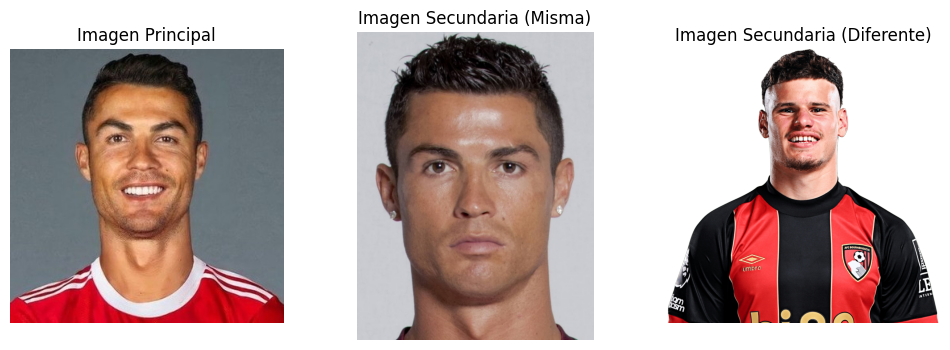

In [11]:

# Función para descargar imágenes con headers (simula navegador)
def download_image(url, filename):
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
        return filename
    else:
        raise Exception(f"No se pudo descargar la imagen: {url}")

# Links de imágenes
url_main = "https://www.clarin.com/img/2021/09/09/-XSm8HJjP_340x340__1.jpg"
url_same = "https://i.pinimg.com/736x/fd/7e/ac/fd7eac51d4a09870d23e33ff95fa6418.jpg"
url_diff = "https://assets.sorare.com/playerpicture/2c85927a-0ec9-4a1c-91b8-5a5b4c768fe6/picture/squared-61918b3ecc34e03358e7ef347f270ba1.png"

# Descargar imágenes
img_main = download_image(url_main, "main.jpg")
img_same = download_image(url_same, "same.jpg")
img_diff = download_image(url_diff, "diff.jpg")

# Mostrar imágenes con títulos
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(Image.open(img_main))
plt.title("Imagen Principal")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(Image.open(img_same))
plt.title("Imagen Secundaria (Misma)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(Image.open(img_diff))
plt.title("Imagen Secundaria (Diferente)")
plt.axis("off")

plt.show()




##Extracción de embeddings y análisis de separabilidad

En este bloque se extraen embeddings faciales con el modelo Facenet de DeepFace, generando un vector numérico para cada rostro.

Se comparan los vectores con distancia euclídea para medir similitud.

Se aplica una reducción de dimensiones (UMAP o PCA como alternativa) para proyectar los embeddings a 2D y visualizar su separabilidad.

Finalmente, se calcula un índice de separabilidad (d_diff / d_same), donde valores mayores a 1 indican que la persona diferente está correctamente más alejada que la misma persona.

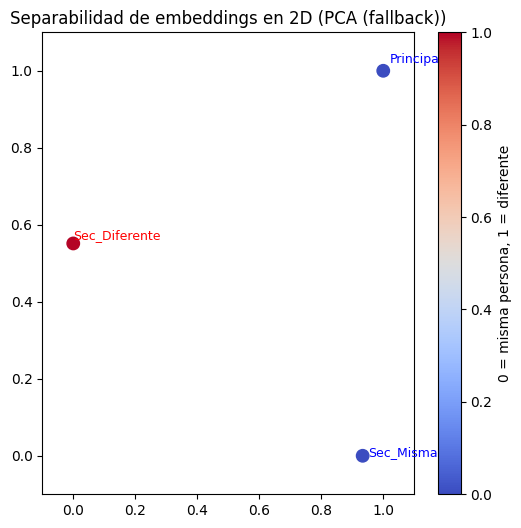

Distancia (main vs same):      9.574655606159492
Distancia (main vs different): 18.72002220002941
 Índice de separabilidad (d_diff / d_same): 1.955164025537527
Separabilidad clara (diferente > misma).


In [14]:
emb_main = DeepFace.represent(img_path=img_main, model_name="Facenet")[0]["embedding"]
emb_same = DeepFace.represent(img_path=img_same, model_name="Facenet")[0]["embedding"]
emb_diff = DeepFace.represent(img_path=img_diff, model_name="Facenet")[0]["embedding"]

Xw_ = np.array([emb_main, emb_same, emb_diff])
labels = np.array([0, 0, 1])  # 0 = misma persona (main, same), 1 = diferente (diff)
names = ["Principal", "Sec_Misma", "Sec_Diferente"]

# -------- reducción a 2D: UMAP si se puede; si no, PCA --------
def embed_2d(X):
    n = X.shape[0]
    scaler = MinMaxScaler()
    try:
        from umap import UMAP
        n_neighbors = max(2, min(10, n - 1))  # seguro para pocos puntos
        umap = UMAP(n_components=2, n_neighbors=n_neighbors, random_state=42)
        Z = umap.fit_transform(X)
        Z = scaler.fit_transform(Z)
        method = "UMAP"
    except Exception:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2, random_state=42)
        Z = pca.fit_transform(X)
        Z = scaler.fit_transform(Z)
        method = "PCA (fallback)"
    return Z, method

X_2D, method = embed_2d(Xw_)

# -------- plot separabilidad --------
plt.figure(figsize=(6,6))
plt.scatter(X_2D[:,0], X_2D[:,1], c=labels, s=80, cmap="coolwarm")
for i, name in enumerate(names):
    plt.text(X_2D[i,0]*1.02, X_2D[i,1]*1.02, name,
             fontsize=9, color="blue" if labels[i]==0 else "red")
plt.xlim([-0.1, 1.1]); plt.ylim([-0.1, 1.1])
plt.title(f"Separabilidad de embeddings en 2D ({method})")
plt.colorbar(label="0 = misma persona, 1 = diferente")
plt.show()

# -------- distancias e índice de separabilidad --------
# (Euclídea)
d_same = np.linalg.norm(np.array(emb_main) - np.array(emb_same))
d_diff = np.linalg.norm(np.array(emb_main) - np.array(emb_diff))
sep_ratio = d_diff / (d_same + 1e-9)  # > 1 ⇒ buena separabilidad

print("Distancia (main vs same):     ", d_same)
print("Distancia (main vs different):", d_diff)
print(" Índice de separabilidad (d_diff / d_same):", sep_ratio)
if sep_ratio > 1.2:
    print("Separabilidad clara (diferente > misma).")
elif sep_ratio > 1.0:
    print("Separabilidad leve.")
else:
    print("Separabilidad pobre (posible confusión).")

Los resultados muestran que la distancia euclídea entre la imagen principal y la secundaria de la misma persona (Cristiano Ronaldo) fue de 9.57, mientras que la distancia entre la imagen principal y la de una persona diferente (Milos Kerkez) fue de 18.72.

El índice de separabilidad calculado (d_diff / d_same = 1.95) confirma que existe una clara diferencia entre ambas comparaciones, ya que la distancia hacia la persona diferente es casi el doble que hacia la misma persona.

La representación 2D mediante reducción de dimensiones evidencia esta separación de manera visual: las dos imágenes de Cristiano Ronaldo aparecen cercanas, mientras que la de Milos Kerkez se ubica claramente apartada.

Por lo tanto, se concluye que el método logra diferenciar de manera efectiva y totalmente separable el rostro de Cristiano Ronaldo respecto al de Milos Kerkez.